In [1]:
#importing necessary libraries
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
from sklearn import preprocessing
import xgboost as xgb
import catboost as cb
import lightgbm as lgbm
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import plotly.express as px
import plotly.graph_objects as go
import optuna
import joblib

c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get paths dataset
path_1st = 'data/1st_test/1st_test'
path_2nd = 'data/2nd_test/2nd_test'
path_3rd = 'data/3rd_test/4th_test/txt'

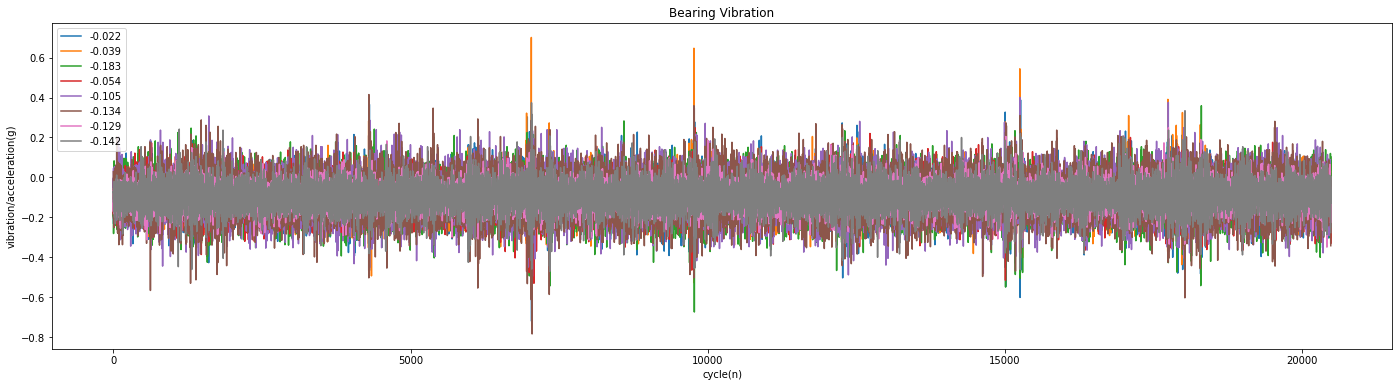

In [3]:
# Test for the first file
dataset = pd.read_csv(f'{path_1st}/2003.10.22.12.06.24', sep='\t')
ax = dataset.plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

In [4]:
# root mean squared sum
def cal_rms(df):
    result = []
    for col in df:
        r = np.sqrt((df[col]**2).sum() / len(df[col]))
        result.append(r)
    return result

# peak-to-peak features
def cal_p2p(df):
    return np.array(df.max().abs() + df.min().abs())

# shannon entropy (cut signals to 500 bins)
def cal_entropy(df):
    ent = []
    for col in df:
        ent.append(entropy(pd.cut(df[col], 500).value_counts()))
    return np.array(ent)

# clearence factor
def cal_clearence(df):
    result = []
    for col in df:
        r = ((np.sqrt(df[col].abs())).sum() / len(df[col]))**2
        result.append(r)
    return result

def cal_features(dataset_path, id_set=None):
    time_features = ['mean','std','skew','kurtosis','entropy','rms','max','p2p', 'crest', 'clearence', 'shape', 'impulse']
    cols1 = ['B1_x','B1_y','B2_x','B2_y','B3_x','B3_y','B4_x','B4_y']
    cols2 = ['B1','B2','B3','B4']
    
    # initialize
    if id_set == 1:
        columns = [c+'_'+tf for c in cols1 for tf in time_features]
        data = pd.DataFrame(columns=columns)
    else:
        columns = [c+'_'+tf for c in cols2 for tf in time_features]
        data = pd.DataFrame(columns=columns)
        
    for filename in os.listdir(dataset_path):
        # read dataset
        raw_data = pd.read_csv(os.path.join(dataset_path, filename), sep='\t')
        
        # time features
        mean_abs = np.array(raw_data.abs().mean())
        std = np.array(raw_data.std())
        skew = np.array(raw_data.skew())
        kurtosis = np.array(raw_data.kurtosis())
        entropy = cal_entropy(raw_data)
        rms = np.array(cal_rms(raw_data))
        max_abs = np.array(raw_data.abs().max())
        p2p = cal_p2p(raw_data)
        crest = max_abs/rms
        clearence = np.array(cal_clearence(raw_data))
        shape = rms / mean_abs
        impulse = max_abs / mean_abs
        
        if id_set == 1:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,8), columns=[c+'_mean' for c in cols1])
            std = pd.DataFrame(std.reshape(1,8), columns=[c+'_std' for c in cols1])
            skew = pd.DataFrame(skew.reshape(1,8), columns=[c+'_skew' for c in cols1])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,8), columns=[c+'_kurtosis' for c in cols1])
            entropy = pd.DataFrame(entropy.reshape(1,8), columns=[c+'_entropy' for c in cols1])
            rms = pd.DataFrame(rms.reshape(1,8), columns=[c+'_rms' for c in cols1])
            max_abs = pd.DataFrame(max_abs.reshape(1,8), columns=[c+'_max' for c in cols1])
            p2p = pd.DataFrame(p2p.reshape(1,8), columns=[c+'_p2p' for c in cols1])
            crest = pd.DataFrame(crest.reshape(1,8), columns=[c+'_crest' for c in cols1])
            clearence = pd.DataFrame(clearence.reshape(1,8), columns=[c+'_clearence' for c in cols1])
            shape = pd.DataFrame(shape.reshape(1,8), columns=[c+'_shape' for c in cols1])
            impulse = pd.DataFrame(impulse.reshape(1,8), columns=[c+'_impulse' for c in cols1])
            
        else:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,4), columns=[c+'_mean' for c in cols2])
            std = pd.DataFrame(std.reshape(1,4), columns=[c+'_std' for c in cols2])
            skew = pd.DataFrame(skew.reshape(1,4), columns=[c+'_skew' for c in cols2])
            kurtosis = pd.DataFrame(kurtosis.reshape(1,4), columns=[c+'_kurtosis' for c in cols2])
            entropy = pd.DataFrame(entropy.reshape(1,4), columns=[c+'_entropy' for c in cols2])
            rms = pd.DataFrame(rms.reshape(1,4), columns=[c+'_rms' for c in cols2])
            max_abs = pd.DataFrame(max_abs.reshape(1,4), columns=[c+'_max' for c in cols2])
            p2p = pd.DataFrame(p2p.reshape(1,4), columns=[c+'_p2p' for c in cols2])
            crest = pd.DataFrame(crest.reshape(1,4), columns=[c+'_crest' for c in cols2])
            clearence = pd.DataFrame(clearence.reshape(1,4), columns=[c+'_clearence' for c in cols2])
            shape = pd.DataFrame(shape.reshape(1,4), columns=[c+'_shape' for c in cols2])
            impulse = pd.DataFrame(impulse.reshape(1,4), columns=[c+'_impulse' for c in cols2])
            
        mean_abs.index = [filename]
        std.index = [filename]
        skew.index = [filename]
        kurtosis.index = [filename]
        entropy.index = [filename]
        rms.index = [filename]
        max_abs.index = [filename]
        p2p.index = [filename]
        crest.index = [filename]
        clearence.index = [filename]
        shape.index = [filename]
        impulse.index = [filename] 
        
        # concat in horizontal axis
        merge = pd.concat([mean_abs, std, skew, kurtosis, entropy, rms, max_abs, p2p,crest,clearence, shape, impulse], axis=1)
        data = data.append(merge)
        
    if id_set == 1:
        cols = [c+'_'+tf for c in cols1 for tf in time_features]
        data = data[cols]
    else:
        cols = [c+'_'+tf for c in cols2 for tf in time_features]
        data = data[cols]
        
    data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
    data = data.sort_index()
    return data    

In [ ]:
set1 = cal_features(path_1st, id_set=1)
set1.to_csv('set1_timefeatures.csv')

In [2]:
set1 = pd.read_csv("./set1_timefeatures.csv")

In [14]:
set1 = set1.rename(columns={'Unnamed: 0':'time'})
set1.set_index('time')
set1.describe()

,B1_x_mean,B1_x_std,B1_x_skew,B1_x_kurtosis,B1_x_entropy,B1_x_rms,B1_x_max,B1_x_p2p,B1_x_crest,B1_x_clearence,...,B4_y_skew,B4_y_kurtosis,B4_y_entropy,B4_y_rms,B4_y_max,B4_y_p2p,B4_y_crest,B4_y_clearence,B4_y_shape,B4_y_impulse
count,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,...,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000,2156.000000
mean,0.127485,0.098575,-0.038621,0.998634,4.981065,0.152221,0.726346,1.177997,4.774991,0.111784,...,0.027031,2.164625,4.842208,0.148647,0.761834,1.314533,4.983898,0.110994,1.183745,5.952366
std,0.006072,0.005345,0.030224,0.197405,0.074409,0.007184,0.079033,0.107634,0.500902,0.005428,...,0.084643,3.346159,0.190066,0.019972,0.395722,0.713627,1.876039,0.010863,0.038067,2.498653
min,0.103651,0.079417,-0.137060,0.279887,4.507776,0.123812,0.510000,0.822000,3.667188,0.090784,...,-1.052182,0.482399,3.715214,0.088486,0.430000,0.681000,2.815276,0.058448,1.055297,2.970951
25%,0.127830,0.096967,-0.058600,0.868275,4.936962,0.152206,0.669000,1.104000,4.407653,0.112297,...,-0.006286,1.045699,4.793158,0.138649,0.547000,0.922000,4.014222,0.107784,1.158352,4.661760
50%,0.128906,0.099051,-0.038491,0.996362,4.983200,0.153733,0.720000,1.175500,4.712466,0.113093,...,0.024396,1.347742,4.869912,0.141205,0.610000,1.062000,4.390117,0.109048,1.165705,5.138212
75%,0.129829,0.101153,-0.017578,1.124417,5.027213,0.155259,0.776000,1.250000,5.063995,0.113818,...,0.060058,1.889175,4.912165,0.159873,0.833500,1.430250,5.088637,0.115484,1.215412,6.147247
max,0.142147,0.129748,0.071573,1.700413,5.304080,0.174977,1.042000,1.533000,7.123639,0.122149,...,1.076577,56.379136,5.335049,0.234521,3.801000,7.122000,19.173531,0.213670,1.386364,25.364433


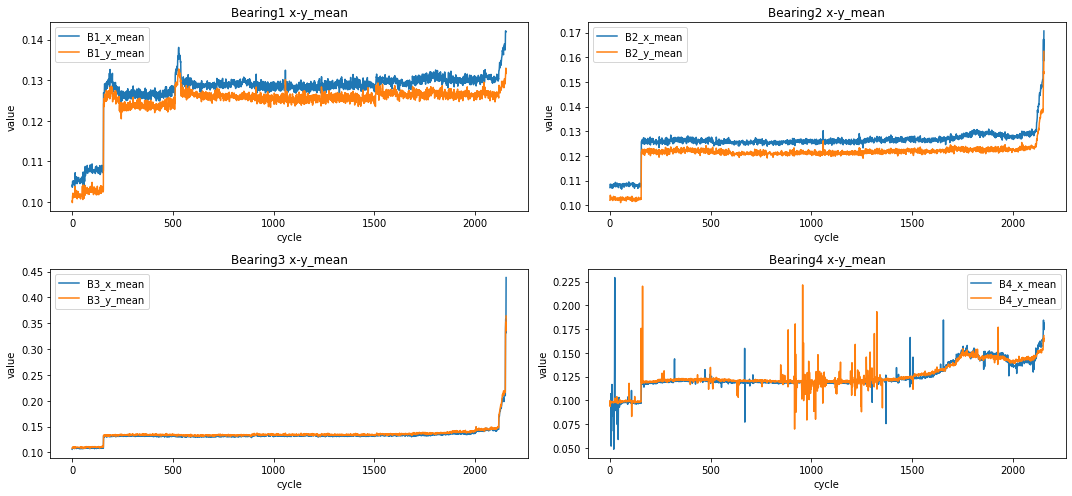

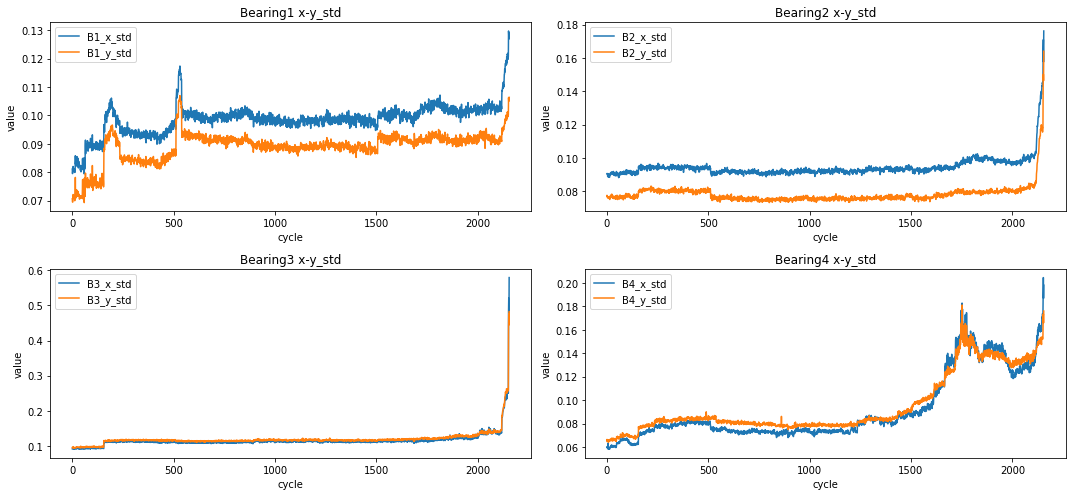

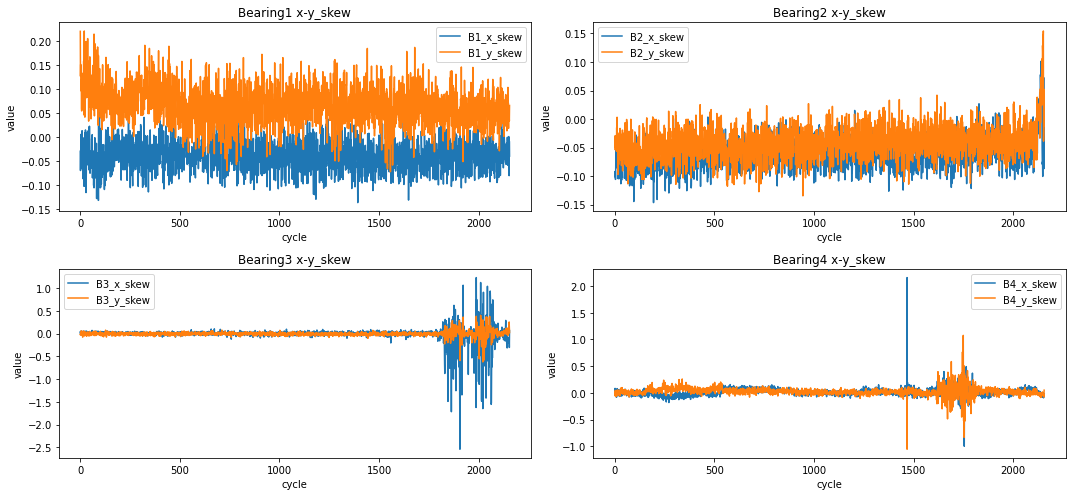

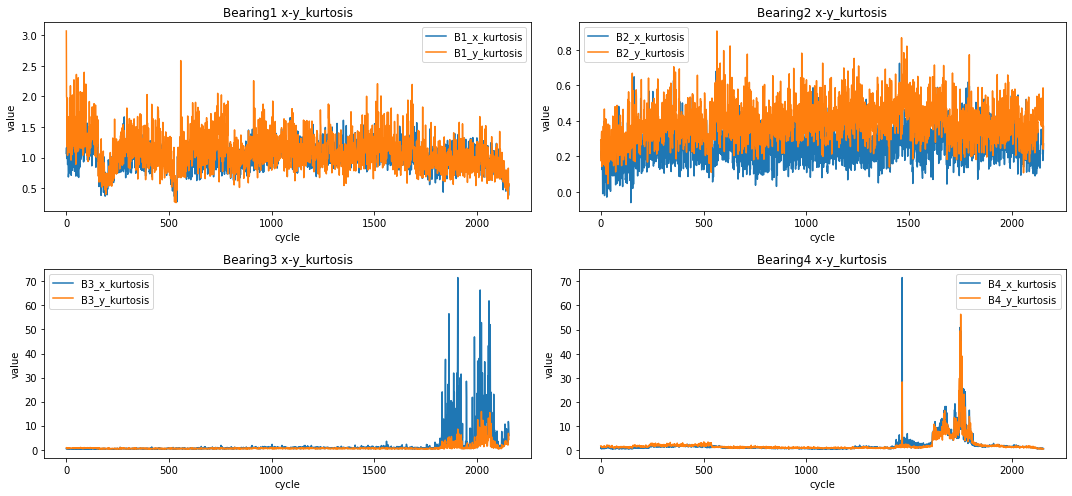

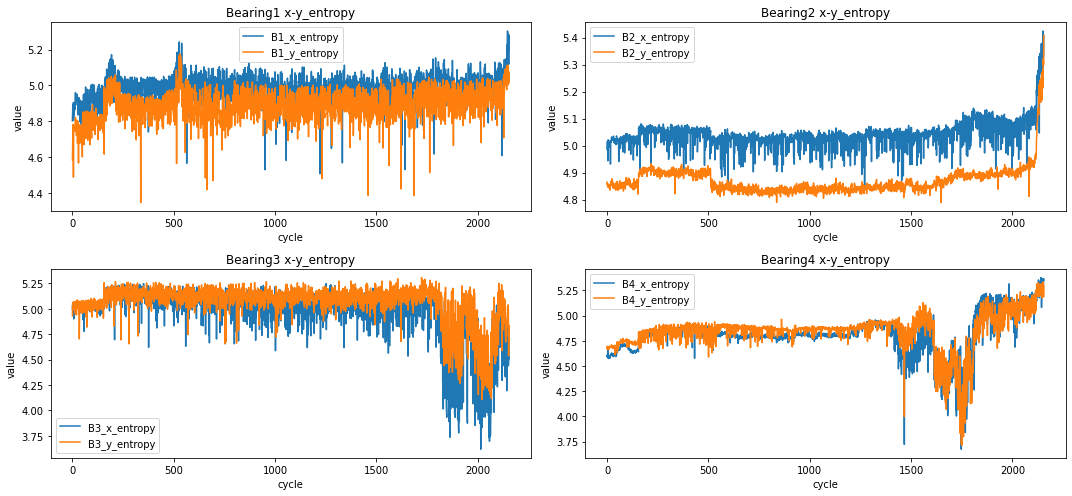

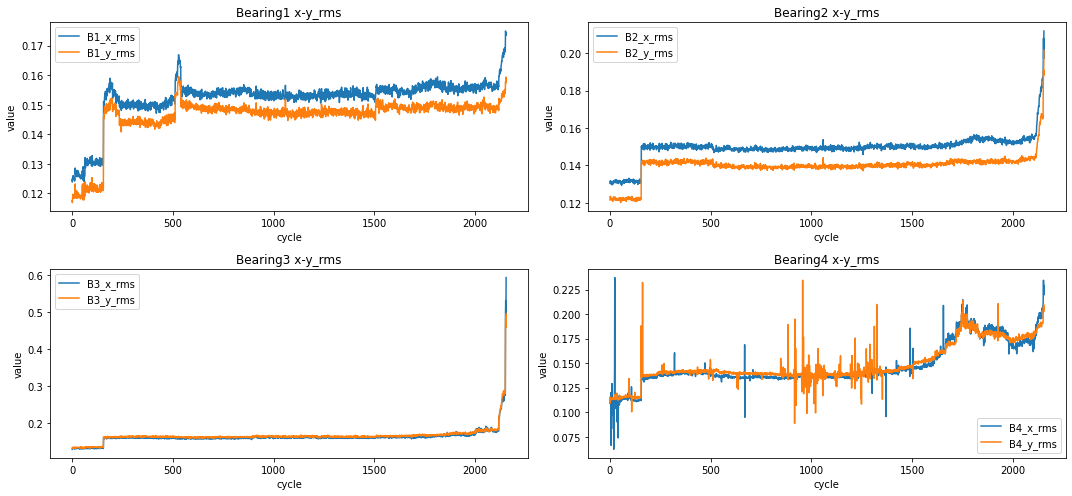

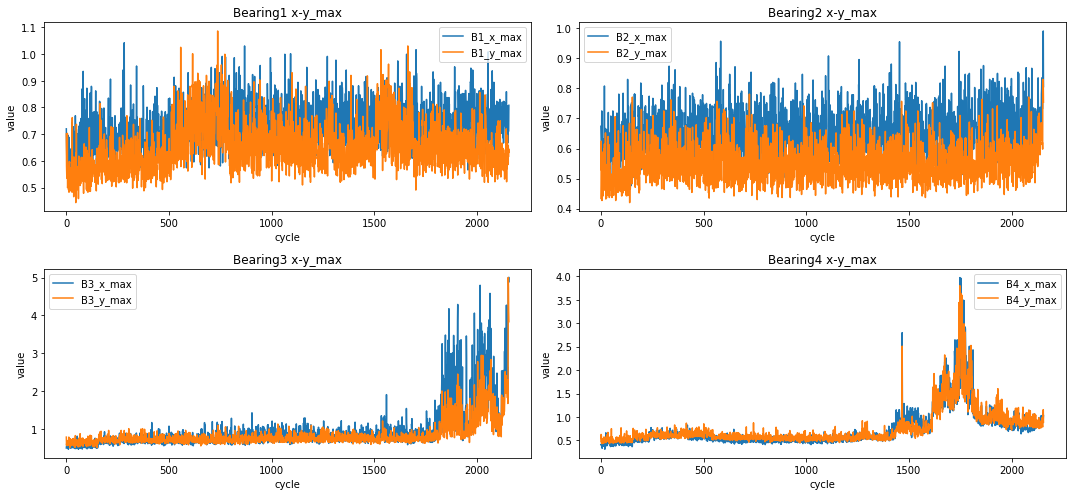

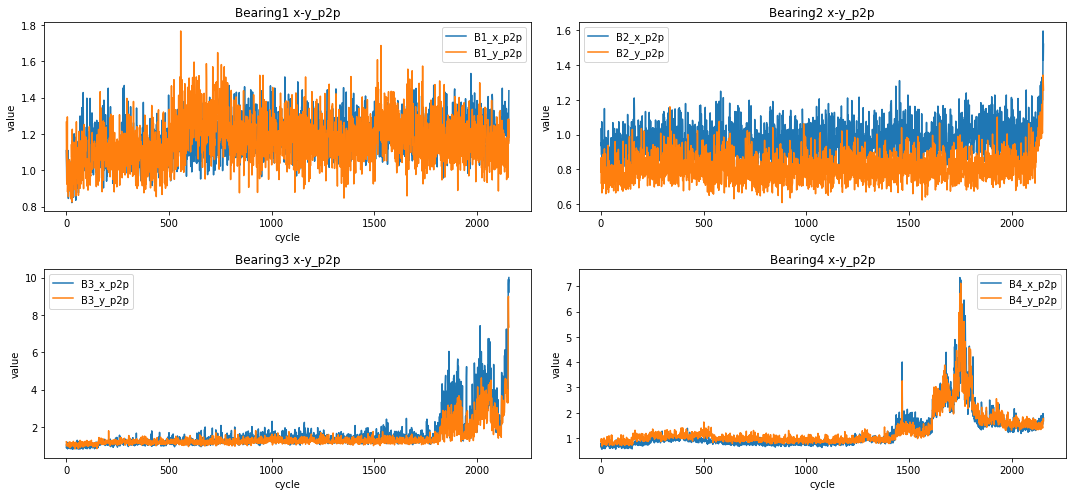

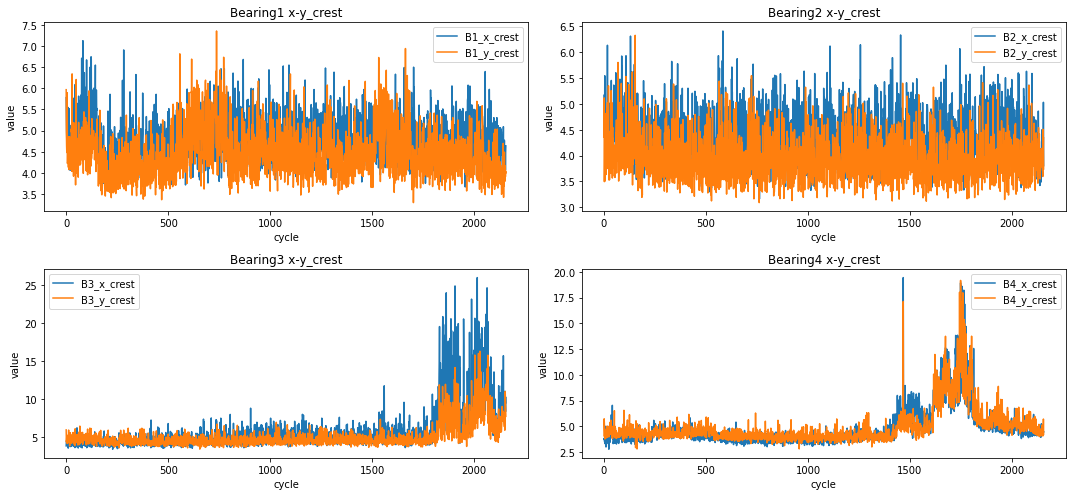

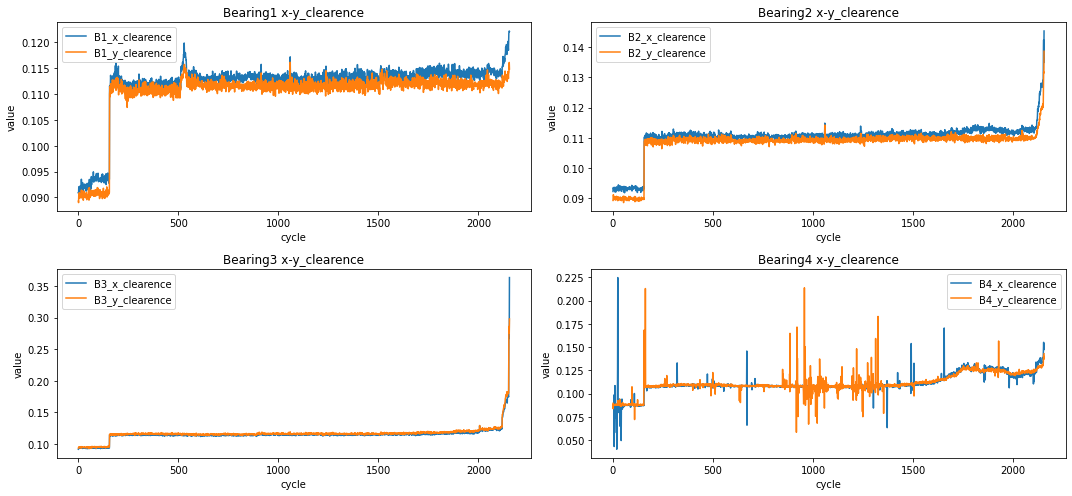

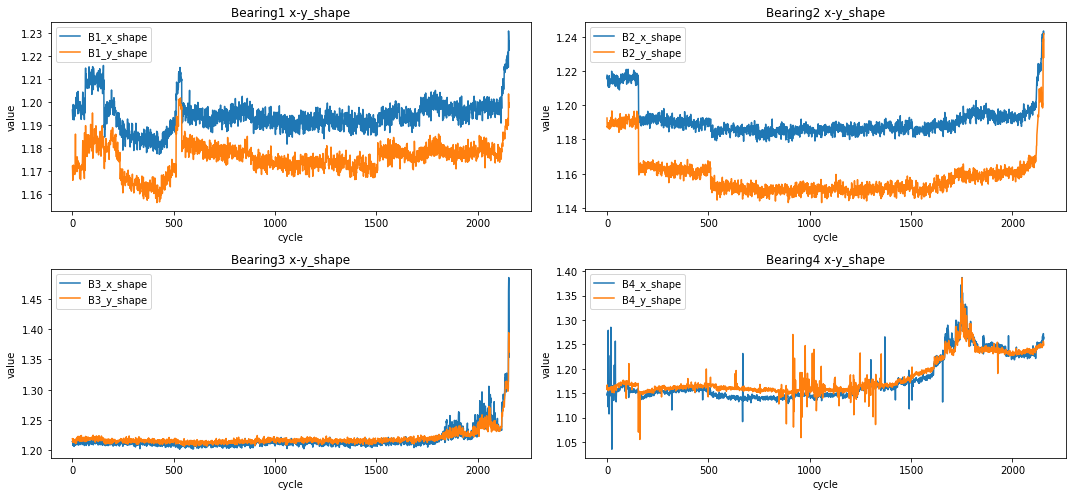

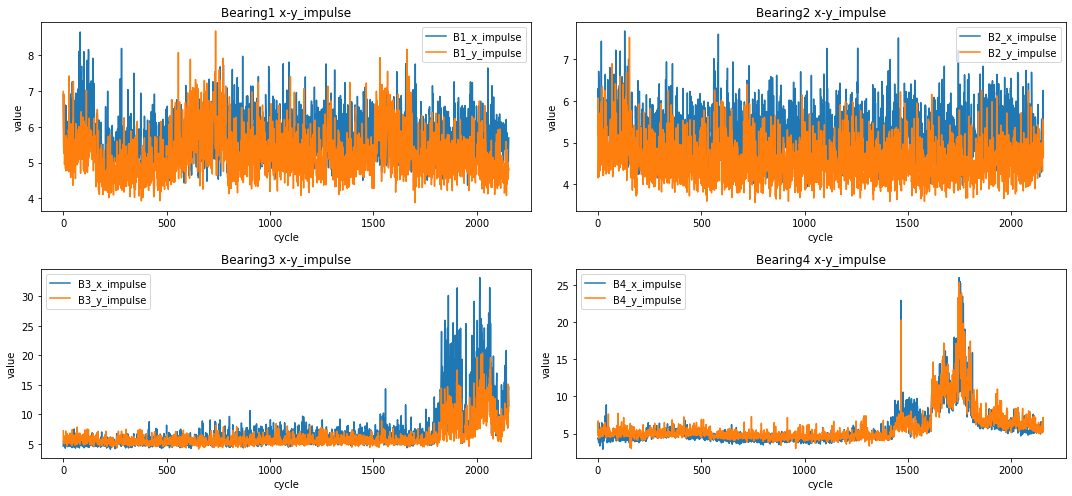

In [10]:
features_list = ["mean","std","skew","kurtosis","entropy","rms","max","p2p", "crest", "clearence", "shape", "impulse"]
bearings_xy = [["B"+str(n)+"_"+str(o)+"_" for n in range(1,5)] for o in ['x','y'] ] 
#print(bearings_xy)
for tf in features_list:
    fig = plt.figure()
    # Divide the figure into a 1x4 grid, and give me the first section
    ax1 = fig.add_subplot(221)
    # Divide the figure into a 1x4 grid, and give me the second section
    ax2 = fig.add_subplot(222)
    #...so on
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    axes = [ax1,ax2,ax3, ax4]
    
    for i in range(4):
        col = bearings_xy[0][i]+tf
        set1[col].plot(figsize = (15,7), title="Bearing{} x-y_".format(i+1)+tf , legend = True, ax=axes[i])
        col = bearings_xy[1][i]+tf
        set1[col].plot(figsize = (15,7) , legend = True, ax=axes[i])
        axes[i].set(xlabel="cycle", ylabel="value")
        fig.tight_layout()

In [12]:
#Health Status labels are added according to following dictionary
B1 ={
    "early" : ["2003-10-22 12:06:24" , "2003-10-23 09:14:13"],
    "suspect" : ["2003-10-23 09:24:13" , "2003-11-08 12:11:44"],
    "normal" : ["2003-11-08 12:21:44" , "2003-11-19 21:06:07"],
    "suspect_1" : ["2003-11-19 21:16:07" , "2003-11-24 20:47:32"],
    "imminent_failure" : ["2003-11-24 20:57:32","2003-11-25 23:39:56"]
}
B2 = {
    "early" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44"],
    "normal" : ["2003-11-01 21:51:44" , "2003-11-24 01:01:24"],
    "suspect" : ["2003-11-24 01:11:24" , "2003-11-25 10:47:32"],
    "imminient_failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B3 = {
    "early" : ["2003-10-22 12:06:24" , "2003-11-01 21:41:44"],
    "normal" : ["2003-11-01 21:51:44" , "2003-11-22 09:16:56"],
    "suspect" : ["2003-11-22 09:26:56" , "2003-11-25 10:47:32"],
    "Inner_race_failure" : ["2003-11-25 10:57:32" , "2003-11-25 23:39:56"]
}

B4 = {
    "early" : ["2003-10-22 12:06:24" , "2003-10-29 21:39:46"],
    "normal" : ["2003-10-29 21:49:46" , "2003-11-15 05:08:46"],
    "suspect" : ["2003-11-15 05:18:46" , "2003-11-18 19:12:30"],
    "Rolling_element_failure" : ["2003-11-19 09:06:09" , "2003-11-22 17:36:56"],
    "Stage_two_failure" : ["2003-11-22 17:46:56" , "2003-11-25 23:39:56"]
}

In [15]:
B1_state = list()
B2_state = list()
B3_state = list()
B4_state = list()
cnt = 0

for row in set1["time"]:
    cnt += 1
    # B1
    if cnt<=151:
        B1_state.append("early")
    if 151 < cnt <=600:
        B1_state.append("suspect")
    if 600 < cnt <=1499:
        B1_state.append("normal")
    if 1499 < cnt <=2098:
        B1_state.append("suspect")
    if 2098 < cnt <= 2156:
        B1_state.append("imminent_failure")
    #B2
    if cnt<=500:
        B2_state.append("early")
    if 500 < cnt <=2000:
        B2_state.append("normal")
    if 2000 < cnt <=2120:
        B2_state.append("suspect")
    if 2120< cnt <=2156:
        B2_state.append("imminet_failure")

    #B3
    if cnt<=500:
        B3_state.append("early")
    if 500 < cnt <= 1790:
        B3_state.append("normal")
    if 1790 < cnt <=2120:
        B3_state.append("suspect")
    if 2120 < cnt <=2156:
        B3_state.append("Inner_race_failure")
    #B4
    if cnt<=200:
        B4_state.append("early")
    if 200 < cnt <=1000:
        B4_state.append("normal")
    if 1000 < cnt <= 1435:
        B4_state.append("suspect")
    if 1435 < cnt <=1840:
        B4_state.append("Inner_race_failure")
    if 1840 < cnt <=2156:
        B4_state.append("Stage_two_failure")
#controlling the counts
from collections import Counter
print(Counter(B1_state))
print(Counter(B2_state))
print(Counter(B3_state))
print(Counter(B4_state))

set1["B1_state"] = B1_state
set1["B2_state"] = B2_state
set1["B3_state"] = B3_state
set1["B4_state"] = B4_state

set1.head()

Counter({'suspect': 1048, 'normal': 899, 'early': 151, 'imminent_failure': 58})
Counter({'normal': 1500, 'early': 500, 'suspect': 120, 'imminet_failure': 36})
Counter({'normal': 1290, 'early': 500, 'suspect': 330, 'Inner_race_failure': 36})
Counter({'normal': 800, 'suspect': 435, 'Inner_race_failure': 405, 'Stage_two_failure': 316, 'early': 200})


,time,B1_x_mean,B1_x_std,B1_x_skew,B1_x_kurtosis,B1_x_entropy,B1_x_rms,B1_x_max,B1_x_p2p,B1_x_crest,...,B4_y_max,B4_y_p2p,B4_y_crest,B4_y_clearence,B4_y_shape,B4_y_impulse,B1_state,B2_state,B3_state,B4_state
0,2003-10-22 12:06:24,0.104148,0.081124,-0.029900,1.069800,4.803057,0.124617,0.720,1.108,5.777714,...,0.471,0.845,4.086202,0.089551,1.158299,4.733045,early,early,early,early
1,2003-10-22 12:09:13,0.103651,0.079519,-0.070118,1.161960,4.844846,0.123812,0.654,1.042,5.282223,...,0.627,0.900,5.741234,0.083762,1.166936,6.699653,early,early,early,early
2,2003-10-22 12:14:13,0.105039,0.080220,-0.041579,0.986724,4.889311,0.125249,0.623,0.940,4.974097,...,0.601,0.977,5.286066,0.088436,1.156631,6.114027,early,early,early,early
3,2003-10-22 12:19:13,0.104900,0.080828,0.005235,1.034758,4.852691,0.125200,0.598,1.055,4.776357,...,0.525,0.852,4.588565,0.088515,1.160373,5.324447,early,early,early,early
4,2003-10-22 12:24:13,0.104779,0.082038,-0.060123,1.110658,4.889993,0.125621,0.623,1.011,4.959370,...,0.522,0.871,4.568532,0.088455,1.160343,5.301063,early,early,early,early


In [24]:
B1_cols = [col for col in set1.columns if "B1" in col]
B2_cols = [col for col in set1.columns if "B2" in col]
B3_cols = [col for col in set1.columns if "B3" in col]
B4_cols = [col for col in set1.columns if "B4" in col]

B1 = set1[B1_cols]
B2 = set1[B2_cols]
B3 = set1[B3_cols]
B4 = set1[B4_cols]
cols = ['Bx_mean','Bx_std','Bx_skew','Bx_kurtosis','Bx_entropy','Bx_rms','Bx_max','Bx_p2p','Bx_crest', 'Bx_clearence', 'Bx_shape', 'Bx_impulse',
        'By_mean','By_std','By_skew','By_kurtosis','By_entropy','By_rms','By_max','By_p2p','By_crest', 'By_clearence', 'By_shape', 'By_impulse','class']
B1.columns = cols
B2.columns = cols
B3.columns = cols
B4.columns = cols
# concat in vertical axis
final_data = pd.concat([B1,B2,B3,B4], axis=0, ignore_index=True)
final_data.describe()

,Bx_mean,Bx_std,Bx_skew,Bx_kurtosis,Bx_entropy,Bx_rms,Bx_max,Bx_p2p,Bx_crest,Bx_clearence,...,By_skew,By_kurtosis,By_entropy,By_rms,By_max,By_p2p,By_crest,By_clearence,By_shape,By_impulse
count,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,...,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000,8624.000000
mean,0.127560,0.100044,-0.024981,1.334116,4.946657,0.152591,0.768281,1.245925,4.944205,0.111824,...,0.012316,1.125540,4.915563,0.149746,0.701041,1.175864,4.606731,0.111392,1.184353,5.481094
std,0.011487,0.021102,0.106187,3.340440,0.195089,0.017037,0.380306,0.658757,1.868630,0.008977,...,0.068697,1.907041,0.164481,0.017631,0.290447,0.532997,1.337560,0.009314,0.030823,1.752930
min,0.048434,0.058210,-2.542674,-0.060380,3.617485,0.062243,0.312000,0.559000,2.790208,0.040238,...,-1.052182,0.045386,3.715214,0.088486,0.420000,0.608000,2.815276,0.058448,1.055297,2.970951
25%,0.124932,0.091431,-0.058129,0.375305,4.879786,0.148059,0.608000,0.940000,4.115825,0.109906,...,-0.029428,0.457801,4.841772,0.140119,0.557000,0.881000,3.942587,0.109000,1.159891,4.615805
50%,0.128211,0.097648,-0.027155,0.806083,5.005758,0.152825,0.693000,1.106000,4.535037,0.112462,...,0.005879,0.767156,4.892254,0.146617,0.627000,1.096000,4.292514,0.110999,1.175230,5.076103
75%,0.131489,0.110512,0.009014,1.124327,5.053243,0.158982,0.789000,1.286250,5.061653,0.114305,...,0.051146,1.219306,5.011436,0.161695,0.732000,1.252000,4.784112,0.115241,1.214024,5.701873
max,0.438427,0.579446,2.157247,71.578220,5.424562,0.593624,5.000000,9.998000,25.948185,0.363341,...,1.076577,56.379136,5.408023,0.496012,5.000000,8.992000,19.173531,0.297790,1.394270,25.364433


In [25]:
X = final_data.copy()
# take label
y = X.pop("class")
# encode label
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
# divide train, test data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, random_state =1)

In [26]:
# calculate accuaracy of train data
xgb_cl = xgb.XGBClassifier(use_label_encoder=False)
xgb_cl.fit(Xtrain, ytrain)
preds = xgb_cl.predict(Xtest)
accuracy_score(ytest, preds)

c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


0.8879443585780525

In [12]:
# use only channel x of each bearing for training
x_axis_cols = ["Bx_"+tf for tf in features_list]
print(x_axis_cols)
X_ = X.copy()
X_ = X[x_axis_cols]
cols = ['B_mean','B_std','B_skew','B_kurtosis','B_entropy',
        'B_rms','B_max','B_p2p','B_crest', 'B_clearence', 'B_shape', 'B_impulse']
X_.columns = cols
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.3, random_state =1)

['Bx_mean', 'Bx_std', 'Bx_skew', 'Bx_kurtosis', 'Bx_entropy', 'Bx_rms', 'Bx_max', 'Bx_p2p', 'Bx_crest', 'Bx_clearence', 'Bx_shape', 'Bx_impulse']


### Model selection

In [13]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA","XGBoost","CatGBoost","LightGBoost"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    xgb.XGBClassifier(),
    cb.CatBoostClassifier(verbose = False),
    lgbm.LGBMClassifier()
    ]

for name, clf in zip(names,classifiers):
    print("training "+name+" ...")
    clf.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print('Score of '+name+' is: '+str(score))
    #iterate over classifiers

training Nearest Neighbors ...
Score of Nearest Neighbors is: 0.7156105100463679
training Linear SVM ...
Score of Linear SVM is: 0.5691653786707882
training RBF SVM ...
Score of RBF SVM is: 0.7187017001545595
training Decision Tree ...
Score of Decision Tree is: 0.731839258114374
training Random Forest ...
Score of Random Forest is: 0.6874034003091191
training Neural Net ...
Score of Neural Net is: 0.6232612055641422
training AdaBoost ...
Score of AdaBoost is: 0.597758887171561
training Naive Bayes ...
Score of Naive Bayes is: 0.5467542503863988
training QDA ...
Score of QDA is: 0.6796754250386399
training XGBoost ...


c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Score of XGBoost is: 0.8423493044822257
training CatGBoost ...
Score of CatGBoost is: 0.8438948995363215
training LightGBoost ...
Score of LightGBoost is: 0.8411901081916537


### Hyperparameter Tuning

In [17]:
def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
        )
    xgb_cl = xgb.XGBClassifier(
            booster='gbtree',
            tree_method ='gpu_hist',
            use_label_encoder=False,
            **xgb_params)
    xgb_cl.fit(X_train, y_train)
    preds = xgb_cl.predict(X_test)
    accuracy_score(y_test, preds)
    return accuracy_score(y_test,preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
xgb_params = study.best_params

[I 2022-12-22 17:40:55,632] A new study created in memory with name: no-name-3a0d06fd-067c-444e-846c-03ca4d93968d
c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2022-12-22 17:43:03,802] Trial 0 finished with value: 0.8442812982998454 and parameters: {'max_depth': 5, 'learning_rate': 0.0008587056787177069, 'n_estimators': 6828, 'min_child_weight': 8, 'colsample_bytree': 0.5509897402811135, 'subsample': 0.7940167395508921, 'reg_alpha': 0.0008396646955100645, 'reg_lambda': 0.014271874991054938}. Best is trial 0 with value: 0.8442812982998454.
c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
[I 2022-12-22 17:43:49,515] Trial 1 finished with value: 0.83887171561

In [18]:
final_model = xgb.XGBClassifier(use_label_encoder=False,
                                **xgb_params)
final_model.fit(X_train, y_train)
preds = final_model.predict(X_test)
accuracy_score(y_test, preds)
#performance is increased

c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


0.8500772797527048

In [29]:
set2 = cal_features(path_2nd, id_set=2)
set2.to_csv('set2_timefeatures.csv')
set3 = cal_features(path_3rd, id_set=3)
set3.to_csv('set3_timefeatures.csv')

In [14]:
set2 = pd.read_csv("./set2_timefeatures.csv")
set3 = pd.read_csv("./set3_timefeatures.csv")
time_2 = set2['Unnamed: 0']
#Setting index columns to time
set2 = set2.rename(columns={'Unnamed: 0':'time'}).set_index('time')
set3 = set3.rename(columns={'Unnamed: 0':'time'}).set_index('time')

In [21]:
B1_cols = [col for col in set2.columns if "B1" in col]
B2_cols = [col for col in set2.columns if "B2" in col]
B3_cols = [col for col in set2.columns if "B3" in col]
B4_cols = [col for col in set2.columns if "B4" in col]

set2_B1 = set2[B1_cols]
set2_B2 = set2[B2_cols]
set2_B3 = set2[B3_cols]
set2_B4 = set2[B4_cols]

set3_B1 = set3[B1_cols]
set3_B2 = set3[B2_cols]
set3_B3 = set3[B3_cols]
set3_B4 = set3[B4_cols]

set2_B1.columns = cols
set2_B2.columns = cols
set2_B3.columns = cols
set2_B4.columns = cols
set3_B1.columns = cols
set3_B2.columns = cols
set3_B3.columns = cols
set3_B4.columns = cols

### Result

In [18]:
final_model = joblib.load("model.pkl")

In [26]:
# HERE number and dataset of bearing can be changed !!!
bearing = set2_B1

#predicting state of bearing with final_model
preds = final_model.predict(bearing)
preds = le.inverse_transform(preds)
#inserting prediction and time to the dataframe
bearing.insert(12,'state',preds)
bearing.insert(13, 'time',bearing.index)

for tf in features_list:
    col = f"B_{tf}"
    print(col)
    fig=go.Figure((go.Scatter(x=bearing['time'], y=bearing[col],
                             mode='lines',
                             line=dict(color='rgba(0,0,220,0.8)'))))
    fig.add_traces(px.scatter(bearing, x='time', y=col, color='state').data)
    fig.update_layout(template='plotly_dark')
    fig.update_xaxes(showgrid=False)
    fig.show()

B_mean


B_std


B_skew


B_kurtosis


B_entropy


B_rms


B_max


B_p2p


B_crest


B_clearence


B_shape


B_impulse


In [38]:
joblib.dump(final_model, 'model.pkl')

['model.pkl']